In [3]:
import tensorflow as tf
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

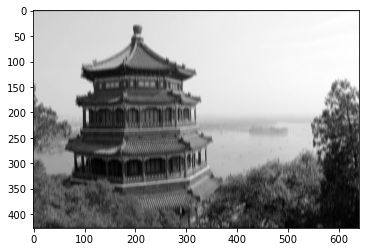

In [6]:
# Ein Bild muss in tensorflow muss ein 3-D Tensor mit den Abmessungen Höhe Breite und Kanäle sein
# Ein Minibatch ist ein 4-D Tensor mit den Abmessungen Größe Minibatch, Höhe, Breite und Kanäle (Farbe e.g. RGB)
# Gewichte eines conv layer ist ein 4 D array , bias ist ein 1 D array

china = load_sample_image("china.jpg") / 255 # pixelquali in jedem farbkanal ist 0 - 255 Byte , dadurch sklaieren auf wert 0-1
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower]) #minibatch
batch_size, height, width, channels = images.shape #4 D tensor

#erstelle 2 filter
filters = np.zeros(shape=(7 ,7, channels, 2), dtype=(np.float32))
filters[:, 3, :, 0] = 1 # vertikale linie
filters[3, :, :, 1] = 1 # horizontale linie

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") # strides könnte auch ein 1-D array sein mit [1, vertikale schrittweite, horizontale schrittweite, 1]
# erstes und letztes element muss erstmal auf 1 gesetzt werden, noch keine implementierung bei keras
# padding same ist mit zero padding, d.h. die      

plt.imshow(outputs[0, :, :, 0], cmap="gray") # zeichne das erste feature map des Bildes

plt.show()

In [ ]:
# in einem echten cnn würden wir nicht wie oben die filter definieren, da filter ein hyperparam ist
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2) #stanard kernel size = stride und padding valid

In [ ]:
# entlang der tiefendimension, nochmehr invariant gegen rotationen,, dicke helligkeit, neigung und farbe eines bildes
outpu = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1,1,1,3), padding="valid") 
# low level api, ersten 3 params legen kernelgröße und schrittweite entlang der batch, höhe und breite dimension
#letzter param legt kernel größe und schrittweite entlang der tiefendimension, es muss ein teiler der eingabetiefe sein (eingabe der vorherigen cnn schicht)

# func api
depth_pool= keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1,1,1,3), padding="valid"))

# berechnet den mittelwert jedes feature map, nützlich für ausgabeschichten
global_avg_pool = keras.layers.GlobalAveragePooling2D()
#entspricht diesen code
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [5]:
fashion_mnist = keras.datasets.fashion_mnist

cnn mit mnist dataset

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, stride=1, activation="relu", padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(pool_size=2), #halbiert jede räumliche dimension
    keras.layers.Conv2D(filters=128, kernel_size=3, stride=1, activation="relu", padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=3, stride=1, activation="relu", padding="same"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, stride=1, activation="relu", padding="same"), # anzahl der wiederholungen der schichten ist ein hyper param (für größere bilder mehr schichten)
    keras.layers.Conv2D(filters=256, kernel_size=3, stride=1, activation="relu", padding="same"), # üblicherweise kann die filter größe verdoppelt werden
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5), # regularisierung, typischer 30-40% bei cnn
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="relu")
])

In [ ]:
alex_net_norm= keras.layers.Lambda(lambda X: tf.nn.local_response_normalization()) #nach einer relu schicht schieben, diese normlaisierung hemmt die aktivsten
#neuronen die an der gleichen stelle in benachbarten feature maps liegenden neuronen -> fördert die spezialisierung von feature maps. sodass sie sich stärker unterscheiden
# und dadurch eine größere bandbreite von merkmalen abdecken

In [ ]:
# resnet 34 

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # übernimmt alle anderen parameter der eltern klasse
        self.activation = keras.activation.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=64, kernel_size=7, stride=2, padding="same", input_shape=[224, 224, 3], use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] *4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [2]:
for filters in [64] * 3 + [128] *4 + [256] * 6 + [512] * 3:
    print(filters)

64
64
64
128
128
128
128
256
256
256
256
256
256
512
512
512


vortrainiertes modell resnet 50 benutzen

In [23]:
# resnet 50 vortrainiert mit imagenet

model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [29]:
china = load_sample_image("china.jpg") # pixelquali in jedem farbkanal ist 0 - 255 Byte , dadurch sklaieren auf wert 0-1
flower = load_sample_image("flower.jpg")
images = np.array([china, flower])
images_resized = tf.image.resize(images, [224, 224]) #resnet c50 erwartet bilder mit 224x224

In [30]:
inputs = keras.applications.resnet50.preprocess_input(images_resized) #resnet möchte pixel werte zwischen 0 - 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


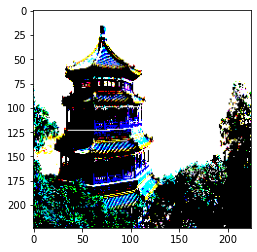

In [31]:
plt.imshow(inputs[0])

In [32]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 0s 124ms/step


In [33]:
Y_proba

array([[2.0904617e-08, 6.2080915e-08, 3.4869164e-08, ..., 3.0669551e-09,
        1.3305251e-07, 8.0237449e-08],
       [5.9631688e-08, 4.5335921e-05, 2.2300387e-07, ..., 3.2232125e-05,
        2.9146445e-03, 1.0838945e-05]], dtype=float32)

In [34]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3) # gibt immer nur die ersten top 3 prob aus
for image_idx in range(len(images)):
    print("Bild #{}".format(image_idx))
    for class_id, name, y_proba in top_K[image_idx]:
        print("{} - {:12s} {:.2f}".format(class_id, name, y_proba*100))

Bild #0
n02825657 - bell_cote    82.35
n03877845 - palace       6.75
n03781244 - monastery    4.19
Bild #1
n03530642 - honeycomb    49.83
n13040303 - stinkhorn    33.95
n02206856 - bee          4.35


transferlearning mit vortrainierte modelle

In [49]:
import tensorflow_datasets as tfds

(train_split, valid_split, test_split), info = tfds.load("tf_flowers", as_supervised=True, with_info=True, split=['train[:70%]', 'train[70%:85%]', 'train[85%:]']) #enthält infos über datensatz
dataset_size = info.splits["train"].num_examples #3670
class_names = info.features["label"].names #["dadelion", "daisy" etc]
n_classes = info.features["label"].num_classes #5

In [50]:
len(train_split)

2569

In [72]:
list(train_split)[0]

(<tf.Tensor: shape=(333, 500, 3), dtype=uint8, numpy=
 array([[[ 93, 122,  30],
         [ 90, 118,  31],
         [ 88, 118,  28],
         ...,
         [247,  77,  78],
         [253,  87,  87],
         [255,  76,  75]],
 
        [[ 98, 125,  30],
         [ 95, 124,  32],
         [ 96, 125,  32],
         ...,
         [247,  81,  83],
         [250,  86,  84],
         [252,  71,  64]],
 
        [[ 98, 126,  26],
         [101, 128,  31],
         [106, 132,  33],
         ...,
         [254,  81,  85],
         [254,  79,  76],
         [252,  55,  47]],
 
        ...,
 
        [[ 35,  51,   6],
         [ 21,  49,   0],
         [ 30,  57,   6],
         ...,
         [224, 239,  78],
         [192, 208,  50],
         [ 88,  54,  53]],
 
        [[ 65,  73,  32],
         [ 20,  46,   0],
         [ 22,  48,   0],
         ...,
         [230, 236,  74],
         [230, 246,  62],
         [ 88,  57,  36]],
 
        [[ 95,  97,  60],
         [ 15,  41,   0],
         [ 23,

In [56]:
img_1 = list(train_split.as_numpy_iterator())[0]

In [70]:
img_1[0]

array([[[ 93, 122,  30],
        [ 90, 118,  31],
        [ 88, 118,  28],
        ...,
        [247,  77,  78],
        [253,  87,  87],
        [255,  76,  75]],

       [[ 98, 125,  30],
        [ 95, 124,  32],
        [ 96, 125,  32],
        ...,
        [247,  81,  83],
        [250,  86,  84],
        [252,  71,  64]],

       [[ 98, 126,  26],
        [101, 128,  31],
        [106, 132,  33],
        ...,
        [254,  81,  85],
        [254,  79,  76],
        [252,  55,  47]],

       ...,

       [[ 35,  51,   6],
        [ 21,  49,   0],
        [ 30,  57,   6],
        ...,
        [224, 239,  78],
        [192, 208,  50],
        [ 88,  54,  53]],

       [[ 65,  73,  32],
        [ 20,  46,   0],
        [ 22,  48,   0],
        ...,
        [230, 236,  74],
        [230, 246,  62],
        [ 88,  57,  36]],

       [[ 95,  97,  60],
        [ 15,  41,   0],
        [ 23,  51,   3],
        ...,
        [210, 224,  40],
        [210, 241,  23],
        [ 93,  87,  11]]

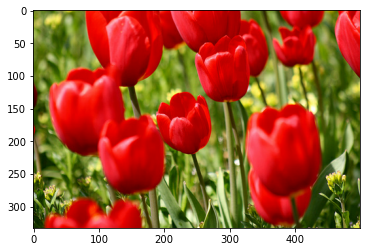

In [71]:
plt.imshow(img_1[0])

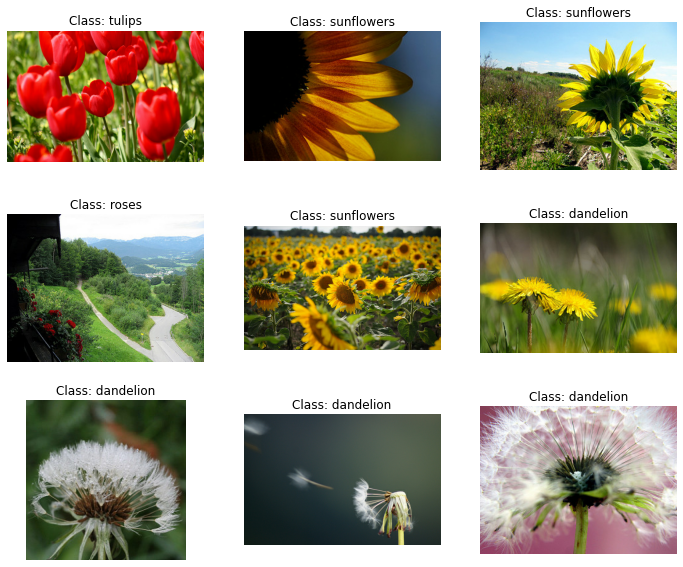

In [74]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_split.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [42]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\Hung\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

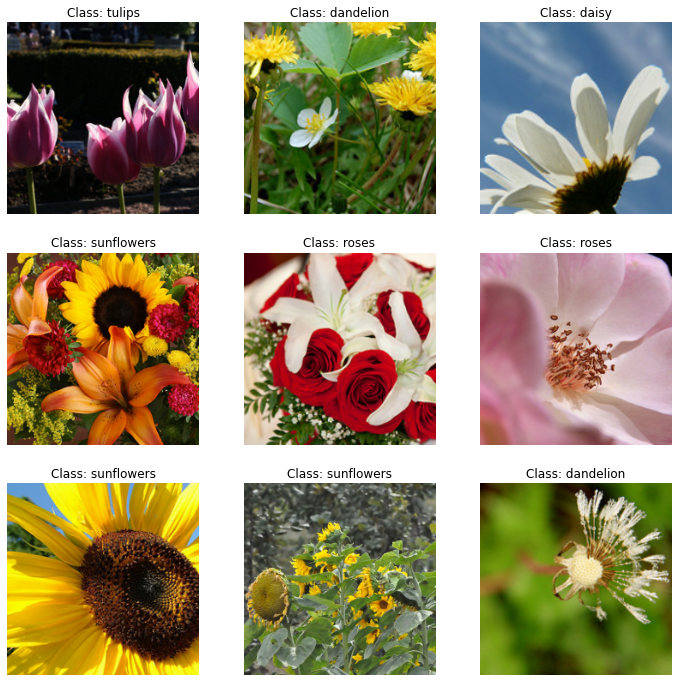

In [75]:
#preprocessing with data augmentation
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_split.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_split.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_split.map(preprocess).batch(batch_size).prefetch(1)

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

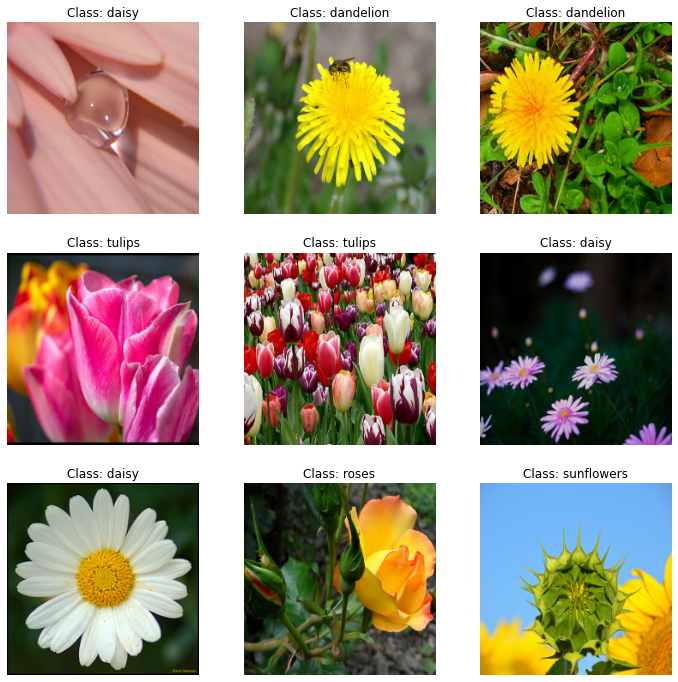

In [76]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [73]:
def preprocess(image, label):
    resized_img = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_img)
    return final_image, label

batch_size = 32
train_set = train_split.shuffle(1000) #durchmischen
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_split.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_split.map(preprocess).batch(batch_size).prefetch(1)


In [ ]:
base_model = keras.applications.Xception(weights="image_net", include_top=False) #global avg pooling layer und dense ausgabeschicht wird weggelassen

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01) #decay = power scheduling; momentum = optimierer
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

In [ ]:
#nach einigen epochen die schichten wieder auftauen
# kleinere lernrate nehmen nehmen um die gewichte der vortrainierten gewichte nicht zu beschädigen

for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Klassifikation und lokalisierung

In [ ]:
# lokalisierung eine regression aufgabe indem man zb. im bild das gesicht mit einer bbox (höhe, breite, horizontale, vertikale koordinaten) erkennt

base_model = keras.applications.Xception(weights="image_net", include_top=False) #global avg pooling layer und dense ausgabeschicht wird weggelassen

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output]) # input muss allerdings auch bbox enthalten in form eines tupel (images, (labels, bbox))

model.compile(loss=["sparse_categorical_crossentropy", "mse"], 
              loss_weights=[0.8, 0.2], #hängt davon ab was wichtig ist
              optimizer=optimizer, metrics=["accuracy"])
